# ACDtools dev sandbox 

#### Date: 2 October, 2024

Author = {"name": "Thomas Moore", "affiliation": "CSIRO", "email": "thomas.moore@csiro.au", "orcid": "0000-0003-3930-1946"}

# Install ACDtools locally

In [1]:
!pip install --user -e /g/data/es60/users/thomas_moore/code/ACDtools

Obtaining file:///g/data/es60/users/thomas_moore/code/ACDtools
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for ACDtools (pyproject.toml) ... done
  Created wheel for ACDtools: filename=ACDtools-0.1-0.editable-py3-none-any.whl size=3514 sha256=b324dd375ef48ee99e137484ba78a3f7d5bbe77aab1711e3159f2b36e69c431b
  Stored in directory: /jobfs/126566523.gadi-pbs/pip-ephem-wheel-cache-mdb_z4d4/wheels/b6/a3/f2/6ce45fbdc116ad50e421d6a11cb060cc796e867501807af446
Successfully built ACDtools
  Attempting uninstall: ACDtools
    Found existing installation: ACDtools 0.1
    Uninstalling ACDtools-0.1:
      Successfully uninstalled ACDtools-0.1


In [18]:
# Enable autoreload in the notebook
%load_ext autoreload
%autoreload 1 
%aimport ACDtools.util
%aimport ACDtools.ard
# Importing from your local package util.py
from ACDtools.util import test_function
from ACDtools.util import detect_compute_platform
from ACDtools.util import load_config
from ACDtools.util import start_dask_cluster_from_config
from ACDtools.util import report_esm_unique
# ard.py
from ACDtools.ard import load_ACCESS_ESM_ensemble

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Notebook settings

### filter warnings

In [4]:
import warnings
warnings.filterwarnings("ignore") # Suppress warnings

# Dask cluster from config
`client, cluster = start_dask_cluster_from_config('netcdf_work')`
<br>OR<br>
`client, cluster = start_dask_cluster_from_config('zarr_work')`

In [5]:
client, cluster = start_dask_cluster_from_config('netcdf_work')

Cluster started with 28 workers.
Dashboard available at: /proxy/8787/status


# Issue: write function to load ACCESS-ESM1.5 data object using intake catalogs at NCI
- https://github.com/Thomas-Moore-Creative/ACDtools/issues/1

## utilise CMIP6 data catalogs for NCI holdings

##### Information on climate data catalogs across Australian HPC

**ACCESS-NRI** https://access-nri-intake-catalog.readthedocs.io/en/latest/usage/how.html <br>
**NCI** https://opus.nci.org.au/pages/viewpage.action?pageId=213713098


##### $\bigstar$ Get inspiration from ACCESS-NRI intake catalog docs: ACCESS-ESM1-5 CMIP6 example
https://access-nri-intake-catalog.readthedocs.io/en/latest/usage/quickstart.html

# import packages

In [6]:
import intake
import xarray as xr
import numpy as np
import gc
import json

### import the ACCESS-NRI catalog

In [7]:
catalog = intake.cat.access_nri

### (1) "I know I want Australian CMIP6 data - so that's fs38 and I need access to that NCI project"

In [8]:
cmip6_fs38_datastore = catalog.search(name='cmip6_fs38').to_source()

### (2) "what are the realms covered by cmip6_fs38?"

In [9]:
report_esm_unique(cmip6_fs38_datastore,keep_list=['realm'])

╒════════════╤═════════════════╕
│ Category   │ Unique values   │
╞════════════╪═════════════════╡
│ realm      │ aerosol         │
│            │ atmos           │
│            │ land            │
│            │ landIce         │
│            │ ocean           │
│            │ ocnBgchem       │
│            │ seaIce          │
╘════════════╧═════════════════╛


### (3) I want to see what variables, over what frequencies, are available in both the 'ocean' & 'oceanBgchem' realms

In [10]:
cmip6_fs38_ocean_datastore = cmip6_fs38_datastore.search(realm=['ocean','ocnBgchem'])

In [12]:
[sorted_unique_dict, table_data] = report_esm_unique(cmip6_fs38_ocean_datastore,return_results=True)

╒════════════════╤═══════════════════════╕
│ Category       │ Unique values         │
╞════════════════╪═══════════════════════╡
│ experiment_id  │ 1pctCO2               │
│                │ 1pctCO2-bgc           │
│                │ 1pctCO2-cdr           │
│                │ 1pctCO2-rad           │
│                │ abrupt-4xCO2          │
│                │ esm-1pct-brch-1000PgC │
│                │ esm-1pct-brch-2000PgC │
│                │ esm-1pct-brch-750PgC  │
│                │ esm-hist              │
│                │ esm-pi-CO2pulse       │
│                │ esm-pi-cdr-pulse      │
│                │ esm-piControl         │
│                │ esm-ssp585            │
│                │ esm-ssp585-ssp126Lu   │
│                │ faf-all               │
│                │ faf-heat              │
│                │ faf-heat-NA0pct       │
│                │ faf-heat-NA50pct      │
│                │ faf-passiveheat       │
│                │ faf-stress            │
│          

# what is the long name of a particular variable?

In [13]:
search = cmip6_fs38_ocean_datastore.search(file_type='l',
                    variable_id='intpp',source_id='ACCESS-ESM1-5',experiment_id='historical')

In [14]:
report_esm_unique(search)

╒════════════════╤═════════════════╕
│ Category       │ Unique values   │
╞════════════════╪═════════════════╡
│ experiment_id  │ historical      │
├────────────────┼─────────────────┤
│ file_type      │ l               │
├────────────────┼─────────────────┤
│ frequency      │ mon             │
├────────────────┼─────────────────┤
│ grid_label     │ gn              │
├────────────────┼─────────────────┤
│ institution_id │ CSIRO           │
├────────────────┼─────────────────┤
│ project_id     │ CMIP            │
├────────────────┼─────────────────┤
│ realm          │ ocnBgchem       │
├────────────────┼─────────────────┤
│ source_id      │ ACCESS-ESM1-5   │
├────────────────┼─────────────────┤
│ table_id       │ Omon            │
├────────────────┼─────────────────┤
│ variable_id    │ intpp           │
╘════════════════╧═════════════════╛


In [15]:
report_esm_unique(search,keep_list=['path'])

╒════════════╤═════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════╕
│ Category   │ Unique values                                                                                                                                                           │
╞════════════╪═════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════╡
│ path       │ /g/data/fs38/publications/CMIP6/CMIP/CSIRO/ACCESS-ESM1-5/historical/r10i1p1f1/Omon/intpp/gn/v20200605/intpp_Omon_ACCESS-ESM1-5_historical_r10i1p1f1_gn_185001-201412.nc │
│            │ /g/data/fs38/publications/CMIP6/CMIP/CSIRO/ACCESS-ESM1-5/historical/r11i1p1f1/Omon/intpp/gn/v20200803/intpp_Omon_ACCESS-ESM1-5_historical_r11i1p1f1_gn_185001-201412.nc │
│            │ /g/data/fs38/publications/CMIP6/CMIP/CSIRO/ACCESS-ESM1-5/his

In [16]:
search.keys()

['l.CMIP.CSIRO.ACCESS-ESM1-5.historical.r10i1p1f1.mon.ocnBgchem.Omon.intpp.gn.v20200605',
 'l.CMIP.CSIRO.ACCESS-ESM1-5.historical.r11i1p1f1.mon.ocnBgchem.Omon.intpp.gn.v20200803',
 'l.CMIP.CSIRO.ACCESS-ESM1-5.historical.r12i1p1f1.mon.ocnBgchem.Omon.intpp.gn.v20200803',
 'l.CMIP.CSIRO.ACCESS-ESM1-5.historical.r13i1p1f1.mon.ocnBgchem.Omon.intpp.gn.v20200803',
 'l.CMIP.CSIRO.ACCESS-ESM1-5.historical.r14i1p1f1.mon.ocnBgchem.Omon.intpp.gn.v20200803',
 'l.CMIP.CSIRO.ACCESS-ESM1-5.historical.r15i1p1f1.mon.ocnBgchem.Omon.intpp.gn.v20200803',
 'l.CMIP.CSIRO.ACCESS-ESM1-5.historical.r16i1p1f1.mon.ocnBgchem.Omon.intpp.gn.v20200803',
 'l.CMIP.CSIRO.ACCESS-ESM1-5.historical.r17i1p1f1.mon.ocnBgchem.Omon.intpp.gn.v20200803',
 'l.CMIP.CSIRO.ACCESS-ESM1-5.historical.r18i1p1f1.mon.ocnBgchem.Omon.intpp.gn.v20200803',
 'l.CMIP.CSIRO.ACCESS-ESM1-5.historical.r19i1p1f1.mon.ocnBgchem.Omon.intpp.gn.v20200803',
 'l.CMIP.CSIRO.ACCESS-ESM1-5.historical.r1i1p1f1.mon.ocnBgchem.Omon.intpp.gn.v20191115',
 'l.CMIP.CS

In [25]:
%%time
ds = xr.concat(
    search.to_dataset_dict(progressbar=False).values(), 
    dim="member"
)

CPU times: user 4.04 s, sys: 633 ms, total: 4.67 s
Wall time: 6.32 s


In [26]:
ds

<xarray.Dataset> Size: 34GB
Dimensions:             (member: 40, time: 1980, bnds: 2, j: 300, i: 360,
                         vertices: 4)
Coordinates:
  * time                (time) datetime64[ns] 16kB 1850-01-16T12:00:00 ... 20...
  * j                   (j) int32 1kB 0 1 2 3 4 5 6 ... 294 295 296 297 298 299
  * i                   (i) int32 1kB 0 1 2 3 4 5 6 ... 354 355 356 357 358 359
    latitude            (j, i) float64 864kB -77.88 -77.88 ... 65.63 65.21
    longitude           (j, i) float64 864kB 80.5 81.5 82.5 ... 79.97 79.99
Dimensions without coordinates: member, bnds, vertices
Data variables:
    time_bnds           (member, time, bnds) datetime64[ns] 1MB dask.array<chunksize=(1, 1, 2), meta=np.ndarray>
    vertices_latitude   (member, j, i, vertices) float64 138MB dask.array<chunksize=(1, 300, 360, 2), meta=np.ndarray>
    vertices_longitude  (member, j, i, vertices) float64 138MB dask.array<chunksize=(1, 300, 360, 2), meta=np.ndarray>
    intpp               (member, time, j, i) float32 34GB dask.array<chunksize=(1, 1, 300, 360), meta=np.ndarray>
Attributes: (12/64)
    Conventions:                      CF-1.7 CMIP-6.2
    activity_id:                      CMIP
    branch_method:                    standard
    branch_time_in_child:             0.0
    branch_time_in_parent:            197231.0
    creation_date:                    2020-09-22T09:39:02Z
    ...                               ...
    intake_esm_attrs:variable_id:     intpp
    intake_esm_attrs:grid_label:      gn
    intake_esm_attrs:version:         v20200922
    intake_esm_attrs:time_range:      185001-201412
    intake_esm_attrs:_data_format_:   netcdf
    intake_esm_dataset_key:           l.CMIP.CSIRO.ACCESS-ESM1-5.historical.r...

In [27]:
%%time
# Get the dictionary of datasets and the corresponding keys (member names)
dataset_dict = search.to_dataset_dict(progressbar=False)
member_names = [key.split('.')[5] for key in dataset_dict.keys()]  # Extract 'r9i1p1f1' as the member name from each key

# Concatenate the datasets along the 'member' dimension and retain the member names
ds2 = xr.concat(
    dataset_dict.values(), 
    dim=xr.DataArray(member_names, dims="member", name="member")
)

CPU times: user 4.08 s, sys: 611 ms, total: 4.69 s
Wall time: 6.79 s


In [28]:
ds2

<xarray.Dataset> Size: 34GB
Dimensions:             (member: 40, time: 1980, bnds: 2, j: 300, i: 360,
                         vertices: 4)
Coordinates:
  * time                (time) datetime64[ns] 16kB 1850-01-16T12:00:00 ... 20...
  * j                   (j) int32 1kB 0 1 2 3 4 5 6 ... 294 295 296 297 298 299
  * i                   (i) int32 1kB 0 1 2 3 4 5 6 ... 354 355 356 357 358 359
    latitude            (j, i) float64 864kB -77.88 -77.88 ... 65.63 65.21
    longitude           (j, i) float64 864kB 80.5 81.5 82.5 ... 79.97 79.99
  * member              (member) <U9 1kB 'r25i1p1f1' 'r29i1p1f1' ... 'r33i1p1f1'
Dimensions without coordinates: bnds, vertices
Data variables:
    time_bnds           (member, time, bnds) datetime64[ns] 1MB dask.array<chunksize=(1, 1, 2), meta=np.ndarray>
    vertices_latitude   (member, j, i, vertices) float64 138MB dask.array<chunksize=(1, 300, 360, 2), meta=np.ndarray>
    vertices_longitude  (member, j, i, vertices) float64 138MB dask.array<chunksize=(1, 300, 360, 2), meta=np.ndarray>
    intpp               (member, time, j, i) float32 34GB dask.array<chunksize=(1, 1, 300, 360), meta=np.ndarray>
Attributes: (12/64)
    Conventions:                      CF-1.7 CMIP-6.2
    activity_id:                      CMIP
    branch_method:                    standard
    branch_time_in_child:             0.0
    branch_time_in_parent:            197231.0
    creation_date:                    2020-09-22T09:39:02Z
    ...                               ...
    intake_esm_attrs:variable_id:     intpp
    intake_esm_attrs:grid_label:      gn
    intake_esm_attrs:version:         v20200922
    intake_esm_attrs:time_range:      185001-201412
    intake_esm_attrs:_data_format_:   netcdf
    intake_esm_dataset_key:           l.CMIP.CSIRO.ACCESS-ESM1-5.historical.r...

In [29]:
# Extract the numeric part from each member name and sort based on it
sorted_member_indices = np.argsort([int(member[1:].split('i')[0]) for member in ds2['member'].values])

# Reorder the dataset based on the sorted member indices
ds_sorted = ds2.isel(member=sorted_member_indices)

# Print to check the sorted members
print(ds_sorted['member'].values)

['r1i1p1f1' 'r2i1p1f1' 'r3i1p1f1' 'r4i1p1f1' 'r5i1p1f1' 'r6i1p1f1'
 'r7i1p1f1' 'r8i1p1f1' 'r9i1p1f1' 'r10i1p1f1' 'r11i1p1f1' 'r12i1p1f1'
 'r13i1p1f1' 'r14i1p1f1' 'r15i1p1f1' 'r16i1p1f1' 'r17i1p1f1' 'r18i1p1f1'
 'r19i1p1f1' 'r20i1p1f1' 'r21i1p1f1' 'r22i1p1f1' 'r23i1p1f1' 'r24i1p1f1'
 'r25i1p1f1' 'r26i1p1f1' 'r27i1p1f1' 'r28i1p1f1' 'r29i1p1f1' 'r30i1p1f1'
 'r31i1p1f1' 'r32i1p1f1' 'r33i1p1f1' 'r34i1p1f1' 'r35i1p1f1' 'r36i1p1f1'
 'r37i1p1f1' 'r38i1p1f1' 'r39i1p1f1' 'r40i1p1f1']


In [30]:
ds_sorted.sel(member = 'r25i1p1f1')

<xarray.Dataset> Size: 864MB
Dimensions:             (time: 1980, bnds: 2, j: 300, i: 360, vertices: 4)
Coordinates:
  * time                (time) datetime64[ns] 16kB 1850-01-16T12:00:00 ... 20...
  * j                   (j) int32 1kB 0 1 2 3 4 5 6 ... 294 295 296 297 298 299
  * i                   (i) int32 1kB 0 1 2 3 4 5 6 ... 354 355 356 357 358 359
    latitude            (j, i) float64 864kB -77.88 -77.88 ... 65.63 65.21
    longitude           (j, i) float64 864kB 80.5 81.5 82.5 ... 79.97 79.99
    member              <U9 36B 'r25i1p1f1'
Dimensions without coordinates: bnds, vertices
Data variables:
    time_bnds           (time, bnds) datetime64[ns] 32kB dask.array<chunksize=(1, 2), meta=np.ndarray>
    vertices_latitude   (j, i, vertices) float64 3MB dask.array<chunksize=(300, 360, 2), meta=np.ndarray>
    vertices_longitude  (j, i, vertices) float64 3MB dask.array<chunksize=(300, 360, 2), meta=np.ndarray>
    intpp               (time, j, i) float32 855MB dask.array<chunksize=(1, 300, 360), meta=np.ndarray>
Attributes: (12/64)
    Conventions:                      CF-1.7 CMIP-6.2
    activity_id:                      CMIP
    branch_method:                    standard
    branch_time_in_child:             0.0
    branch_time_in_parent:            197231.0
    creation_date:                    2020-09-22T09:39:02Z
    ...                               ...
    intake_esm_attrs:variable_id:     intpp
    intake_esm_attrs:grid_label:      gn
    intake_esm_attrs:version:         v20200922
    intake_esm_attrs:time_range:      185001-201412
    intake_esm_attrs:_data_format_:   netcdf
    intake_esm_dataset_key:           l.CMIP.CSIRO.ACCESS-ESM1-5.historical.r...

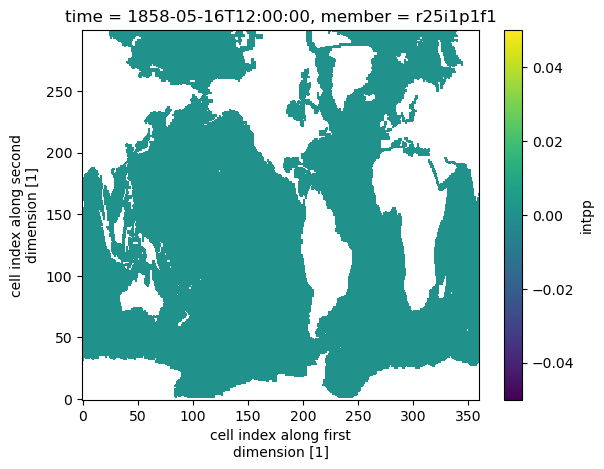

In [31]:
(ds2.isel(member = 0).isel(time=100) - (ds_sorted.sel(member = 'r25i1p1f1').isel(time=100))).intpp.plot()

In [ ]:
cmip6_datastore_filtered = cmip6_datastore.search(
    source_id="ACCESS-ESM1-5", 
    table_id="Omon", 
    variable_id="tos", 
    experiment_id="historical", 
    file_type="l"
)

cmip6_datastore_filtered